# 2. Model Development with PyTorch and Export with ONNX

In [1]:
import matplotlib.pyplot as plt
import time

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from emnist_dl2prod.utils import load_emnist, show_img, show_train_progress

# Get Data

In [2]:
emnist_folder_path = "emnist_data/"
x_train, y_train, x_test, y_test, mapping = load_emnist(emnist_folder_path)

[2018-09-09 13:58:29] INFO:emnist_dl2prod.utils:Loading train and test data from emnist_data/emnist-byclass.mat


In [3]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]
# Conduct ea. evaluation step during training
# on just 5% of the overall test data
n_test_sample = int(n_test * 0.05)
width_px, height_px = 28, 28
n_input_feat = width_px*height_px
n_classes = mapping.shape[0]

# Model exploration

## 1. Model: Linear Model (LM) (Shallow Neural Network)

### 1.1 Data preprocessing
* Reshaping
* Type conversion
* Normalizing

In [5]:
# Train Data: NumPy to PyTorch
x_train_tensor = torch.from_numpy(x_train) / 255
x_train_tensor_flatten = x_train_tensor.reshape(n_train, -1)
# Torch does not expect the target classes to be one-hot-encoded
y_train_tensor = torch.from_numpy(y_train.astype(np.int64))

# Test Data: NumPy to PyTorch
x_test_tensor = torch.from_numpy(x_test) / 255
x_test_tensor_flatten = x_test_tensor.reshape(n_test, -1)
y_test_tensor = torch.from_numpy(y_test.astype(np.int64))

Take a randomly chosen subset of the testing data (5%)

In [6]:
sample_idxs = torch.randint(0, n_test, size=(n_test_sample,), dtype=torch.long)
x_test_tensor_sample = x_test_tensor[sample_idxs]
x_test_tensor_flatten_sample = x_test_tensor_flatten[sample_idxs]
y_test_tensor_sample = y_test_tensor[sample_idxs]

### 1.2 Model, Performance criterion and Optimizer definition

In [7]:
class LinearImgClassifier(torch.nn.Module):
    def __init__(self, n_input_feat, n_classes):
        super(LinearImgClassifier, self).__init__()
        self.linear = torch.nn.Linear(n_input_feat, n_classes)
    
    def forward(self, x):
        y_pred = F.softmax(self.linear(x), dim=1)
        return y_pred

No. of Features to train for a simple linear layer

In [8]:
n_input_feat*n_classes+n_classes

48670

In [9]:
linear_model = LinearImgClassifier(n_input_feat, n_classes)
model = linear_model

In [10]:
criterion = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)

### 1.3 Hyperparameter definition

In [11]:
n_epochs = 5
batch_size = 128
n_batches = n_train // batch_size
eval_after_n_batches = 20

### 1.4 Model training

In [12]:
print(linear_model)

LinearImgClassifier(
  (linear): Linear(in_features=784, out_features=62, bias=True)
)


In [13]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
    for batch in range(n_batches):
        idxs = torch.randint(0, n_train, size=(batch_size,), dtype=torch.long)
        x_batch, y_batch = x_train_tensor_flatten[idxs], y_train_tensor[idxs]
                
        optimizer.zero_grad()
        
        # 1. Forward Pass
        y_pred = model(x_batch)
        
        # 2. Loss Calculation
        train_loss = criterion(y_pred, y_batch.flatten())
        
        # 3. Backward Pass
        train_loss.backward()
        
        # 4. Parameter Update
        optimizer.step()
        
        # 5. Track Model Performance on Train and Test Data
        if not batch % eval_after_n_batches:
            y_class_pred_train = model(x_batch)
            y_class_pred_test = model(x_test_tensor_flatten_sample)
            y_train_acc = (torch.argmax(y_class_pred_train, 1) == y_batch.flatten()).sum().item()/batch_size
            y_test_acc = (torch.argmax(y_class_pred_test, 1) == y_test_tensor_sample.flatten()).sum().item()/n_test_sample
            train_accuracy.append(y_train_acc)
            test_accuracy.append(y_test_acc)
            train_losses.append(train_loss.item())
            test_losses.append(criterion(y_class_pred_test, y_test_tensor_sample.flatten()).item())
            # comment out to keep the Notebook length on GitHub short
            # show_train_progress(epoch*n_batches+batch,
            #                     train_losses[-1], test_losses[-1],
            #                     train_accuracy[-1], test_accuracy[-1])

### 1.5 Model performance visualization

[]

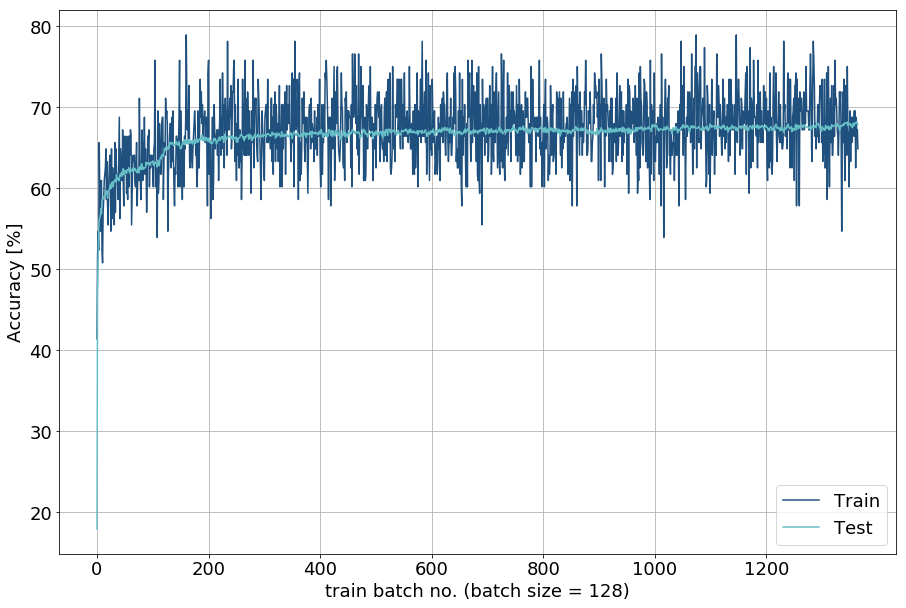

In [14]:
fs = 18
plt.figure(figsize=(15,10))
plt.plot(range(len(train_accuracy)), train_accuracy, '#20517e', label='Train')
plt.plot(range(len(train_accuracy)), test_accuracy, '#66bec6', label='Train')
plt.grid(True)
plt.xlabel("train batch no. (batch size = {})".format(batch_size), fontsize=fs)
plt.ylabel("Accuracy [%]", fontsize=fs)
plt.yticks(np.arange(0.1, 1.0, 0.1), np.arange(10, 100, 10), fontsize=fs)
x_interval = np.arange(0, n_epochs*n_batches/eval_after_n_batches+10, 200).astype(int)
plt.xticks(x_interval, x_interval, fontsize=fs)
plt.legend(['Train', 'Test'], fontsize=fs)
plt.plot()

In [15]:
lm_train_acc = train_accuracy
lm_test_acc = test_accuracy

## 2. Model: Deep Neural Network (DNN)

### 2.1 Data preprocessing

We can just reuse the data from the linear model

### 2.2 Model, Performance criterion and Optimizer definition

In [16]:
n_hidden_1 = 512
n_hidden_2 = 256

In [17]:
class DNNImgClassifier(torch.nn.Module):
    def __init__(self, n_input_feat, n_hidden_1, n_hidden_2, n_classes):
        super(DNNImgClassifier, self).__init__()
        self.linear_1 = torch.nn.Linear(n_input_feat, n_hidden_1)
        self.linear_2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.linear_3 = torch.nn.Linear(n_hidden_2, n_classes)
    
    def forward(self, x):
        logit_1 = self.linear_1(x)
        activ_1 = F.elu(logit_1)
        logit_2 = self.linear_2(activ_1)
        activ_2 = F.elu(logit_2)
        logit_3 = self.linear_3(activ_2)
        y_pred = F.softmax(logit_3, dim=1)
        return y_pred

No. of Features to train for a simple linear layer

In [18]:
n_input_feat*n_hidden_1+n_hidden_1+n_hidden_1*n_hidden_2+n_hidden_2+n_hidden_2*n_classes+n_classes

549182

In [19]:
dnn_model = DNNImgClassifier(n_input_feat, n_hidden_1, n_hidden_2, n_classes)
criterion = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=0.0003)

### 2.3 Hyperparameter definition

In [20]:
n_epochs = 5
batch_size = 128
n_batches = n_train // batch_size
eval_after_n_batches = 20

### 2.4 Model training

In [21]:
print(dnn_model)

DNNImgClassifier(
  (linear_1): Linear(in_features=784, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (linear_3): Linear(in_features=256, out_features=62, bias=True)
)


In [22]:
model = dnn_model

In [23]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
    for batch in range(n_batches):
        idxs = torch.randint(0, n_train, size=(batch_size,), dtype=torch.long)
        x_batch, y_batch = x_train_tensor_flatten[idxs], y_train_tensor[idxs]
                
        optimizer.zero_grad()
        
        # 1. Forward Pass
        y_pred = model(x_batch)
        
        # 2. Loss Calculation
        train_loss = criterion(y_pred, y_batch.flatten())
        
        # 3. Backward Pass
        train_loss.backward()
        
        # 4. Parameter Update
        optimizer.step()
        
        # 5. Track Model Performance on Train and Test Data
        if not batch % eval_after_n_batches:
            y_class_pred_train = model(x_batch)
            y_class_pred_test = model(x_test_tensor_flatten_sample)
            y_train_acc = (torch.argmax(y_class_pred_train, 1) == y_batch.flatten()).sum().item()/batch_size
            y_test_acc = (torch.argmax(y_class_pred_test, 1) == y_test_tensor_sample.flatten()).sum().item()/n_test_sample
            train_accuracy.append(y_train_acc)
            test_accuracy.append(y_test_acc)
            train_losses.append(train_loss.item())
            test_losses.append(criterion(y_class_pred_test, y_test_tensor_sample.flatten()).item())
            # comment out to keep the Notebook length on GitHub short
            # show_train_progress(epoch*n_batches+batch,
            #                     train_losses[-1], test_losses[-1],
            #                     train_accuracy[-1], test_accuracy[-1])

### 2.5 Model performance visualization

[]

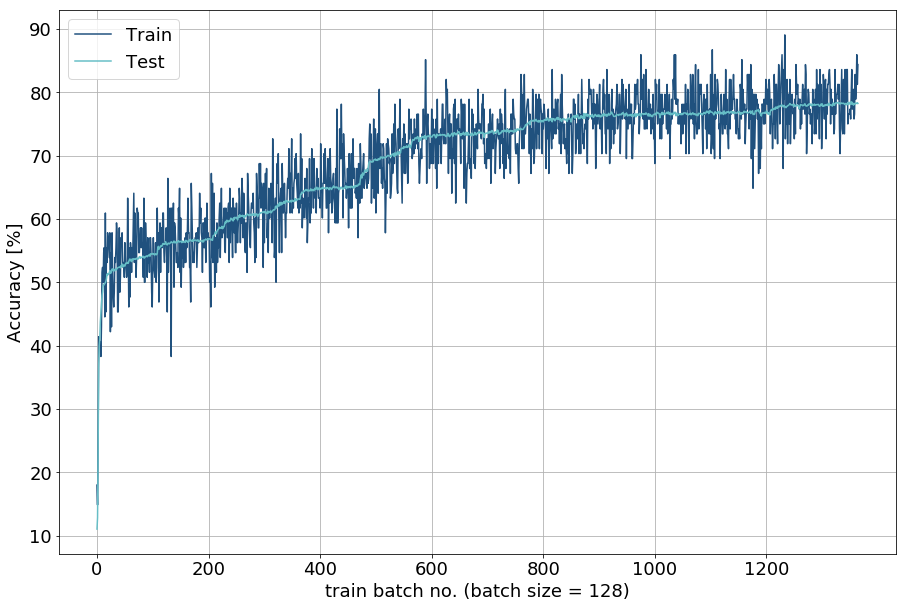

In [24]:
fs = 18
plt.figure(figsize=(15,10))
plt.plot(range(len(train_accuracy)), train_accuracy, '#20517e', label='Train')
plt.plot(range(len(train_accuracy)), test_accuracy, '#66bec6', label='Train')
plt.grid(True)
plt.xlabel("train batch no. (batch size = {})".format(batch_size), fontsize=fs)
plt.ylabel("Accuracy [%]", fontsize=fs)
plt.yticks(np.arange(0.1, 1.0, 0.1), np.arange(10, 100, 10), fontsize=fs)
x_interval = np.arange(0, n_epochs*n_batches/eval_after_n_batches+10, 200).astype(int)
plt.xticks(x_interval, x_interval, fontsize=fs)
plt.legend(['Train', 'Test'], fontsize=fs)
plt.plot()

In [27]:
dnn_train_acc = train_accuracy
dnn_test_acc = test_accuracy

## 3. Model: Convolutional neural network with multiple convolutions

### 3.1 Data preprocessing
We roughly keep our existing data, but now we move to use the unflattened images and introduce another dimension to reflect the color channel.

In [ ]:
x_train_tensor_cnn = x_train_tensor.reshape(n_train, 1, width_px, height_px)
x_test_tensor_cnn = x_test_tensor.reshape(n_test, 1, width_px, height_px)
x_test_tensor_cnn_sample = x_test_tensor_cnn[sample_idxs]

### 3.2 Model, Performance criterion and Optimizer definition

In [ ]:
filter_1 = (1, 3, 4)  # (in_channels, out_channels, kernel_size)
filter_2 = (3, 9, 4)
n_fc_layer = 256

In [ ]:
class CNNImgClassifier(torch.nn.Module):
    def __init__(self, filter_1, filter_2, n_fc_layer):
        super(CNNImgClassifier, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=filter_1[0],
                                      out_channels=filter_1[1],
                                      kernel_size=filter_1[2])
        self.conv_2 = torch.nn.Conv2d(in_channels=filter_2[0],
                                      out_channels=filter_2[1],
                                      kernel_size=filter_2[2])
        self.linear_1 = torch.nn.Linear(filter_2[1]*20*20, n_fc_layer)
        self.linear_2 = torch.nn.Linear(n_fc_layer, n_classes)
    
    def forward(self, x):
        logit_1 = F.relu(self.conv_1(x))
        activ_1 = F.max_pool2d(logit_1, kernel_size=2, stride=1)
        logit_2 = F.relu(self.conv_2(activ_1))
        activ_2 = F.max_pool2d(logit_2, kernel_size=2, stride=1).reshape(-1, 9*20*20)
        logit_3 = self.linear_1(activ_2)
        activ_3 = F.elu(logit_3)
        logit_4 = self.linear_2(activ_3)
        y_pred = F.softmax(logit_4, dim=1)
        return y_pred

No. of Features to train for a simple linear layer

In [ ]:
cnn_model.conv_2.weight.shape

In [ ]:
cnn_model.conv_1.weight.numel()+cnn_model.conv_2.weight.numel()+\
+cnn_model.linear_1.weight.numel()+cnn_model.linear_2.weight.numel()+\
cnn_model.conv_1.bias.numel()+cnn_model.conv_2.bias.numel()+\
+cnn_model.linear_1.bias.numel()+cnn_model.linear_2.bias.numel()

In [ ]:
cnn_model = CNNImgClassifier(filter_1, filter_2, n_fc_layer)
criterion = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0003)

### 3.3 Hyperparameter definition

In [ ]:
n_epochs = 1
batch_size = 128
n_batches = n_train // batch_size
eval_after_n_batches = 20

### 3.4 Model training

In [ ]:
print(model)

In [ ]:
model = cnn_model

In [ ]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
    for batch in range(n_batches):
        idxs = torch.randint(0, n_train, size=(batch_size,), dtype=torch.long)
        x_batch, y_batch = x_train_tensor_cnn[idxs], y_train_tensor[idxs]
                
        optimizer.zero_grad()
        
        # 1. Forward Pass
        y_pred = model(x_batch)
        
        # 2. Loss Calculation
        train_loss = criterion(y_pred, y_batch.flatten())
        
        # 3. Backward Pass
        train_loss.backward()
        
        # 4. Parameter Update
        optimizer.step()
        
        # 5. Track Model Performance on Train and Test Data
        if not batch % eval_after_n_batches:
            y_class_pred_train = model(x_batch)
            y_class_pred_test = model(x_test_tensor_cnn_sample)
            y_train_acc = (torch.argmax(y_class_pred_train, 1) == y_batch.flatten()).sum().item()/batch_size
            y_test_acc = (torch.argmax(y_class_pred_test, 1) == y_test_tensor_sample.flatten()).sum().item()/n_test_sample
            train_accuracy.append(y_train_acc)
            test_accuracy.append(y_test_acc)
            train_losses.append(train_loss.item())
            test_losses.append(criterion(y_class_pred_test, y_test_tensor_sample.flatten()).item())
            show_train_progress(epoch*n_batches+batch,
                                train_losses[-1], test_losses[-1],
                                train_accuracy[-1], test_accuracy[-1])

### 3.5 Model performance visualization

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(len(train_accuracy)), train_accuracy, 'b-', label='Train')
plt.plot(range(len(train_accuracy)), test_accuracy, 'g-', label='Train')
plt.grid(True)
plt.xlabel("train batch no. (batch size = {})".format(batch_size), fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(['Train', 'Test'], fontsize=14)
plt.plot()

## Model Performance Comparison and Model Export

[]

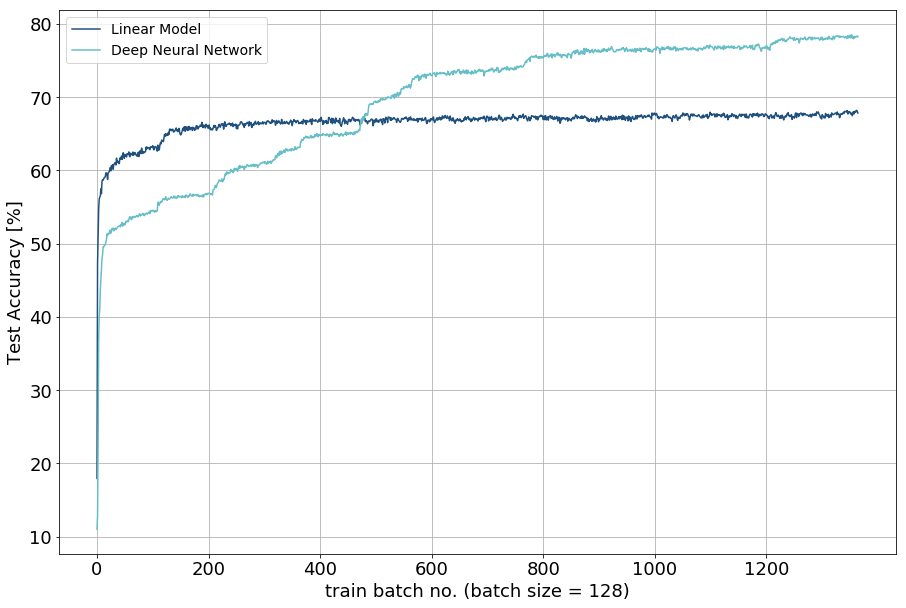

In [29]:
fs = 18
plt.figure(figsize=(15,10))
plt.plot(range(len(train_accuracy)), lm_test_acc, '#20517e', label='Linear Model')
plt.plot(range(len(train_accuracy)), dnn_test_acc, '#66bec6', label='Deep Neural Network')
plt.grid(True)
plt.xlabel("train batch no. (batch size = {})".format(batch_size), fontsize=fs)
plt.ylabel("Test Accuracy [%]", fontsize=fs)
x_interval = np.arange(0, n_epochs*n_batches/eval_after_n_batches+10, 200).astype(int)
plt.xticks(x_interval, x_interval, fontsize=fs)
plt.yticks(np.arange(0.1, 1.0, 0.1), np.arange(10, 100, 10), fontsize=fs)
plt.legend(['Linear Model', 'Deep Neural Network'], fontsize=14)
plt.plot()

## Model Export using ONNX

OK. SO after some quick research, I came across the [Open Neural Network Exchange (ONNX) ecosystem for interachangeable AI model](https://github.com/onnx/onnx).

Though, there is currently no support for importing ONNX models to PyTorch, it is possible to export them to ONNX. This is what we need and already an integral part of PyTorch (**torch.onnx**). 

The output is a binary protobuf file which contains both the network structure and parameters of the model (in our case the simple classifier)

`https://pytorch.org/docs/master/onnx.html`

In [30]:
dnn_model

DNNImgClassifier(
  (linear_1): Linear(in_features=784, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (linear_3): Linear(in_features=256, out_features=62, bias=True)
)

In [31]:
example_input = torch.randn(1,784)

In [32]:
torch.onnx.export(dnn_model,
                  example_input,
                  "../models/dnn_model_pt.onnx",
                  input_names=["flattened_rescaled_img_28x28"] + \
                              ["weight_1", "bias_1",
                               "weight_2", "bias_2",
                               "weight_3", "bias_3"],
                  output_names=["softmax_probabilities"],
                  verbose=True)

graph(%flattened_rescaled_img_28x28 : Float(1, 784)
      %weight_1 : Float(512, 784)
      %bias_1 : Float(512)
      %weight_2 : Float(256, 512)
      %bias_2 : Float(256)
      %weight_3 : Float(62, 256)
      %bias_3 : Float(62)) {
  %7 : Float(1, 512) = onnx::Gemm[alpha=1, beta=1, broadcast=1, transB=1](%flattened_rescaled_img_28x28, %weight_1, %bias_1), scope: DNNImgClassifier/Linear[linear_1]
  %8 : Float(1, 512) = onnx::Elu[alpha=1](%7), scope: DNNImgClassifier
  %9 : Float(1, 256) = onnx::Gemm[alpha=1, beta=1, broadcast=1, transB=1](%8, %weight_2, %bias_2), scope: DNNImgClassifier/Linear[linear_2]
  %10 : Float(1, 256) = onnx::Elu[alpha=1](%9), scope: DNNImgClassifier
  %11 : Float(1, 62) = onnx::Gemm[alpha=1, beta=1, broadcast=1, transB=1](%10, %weight_3, %bias_3), scope: DNNImgClassifier/Linear[linear_3]
  %softmax_probabilities : Float(1, 62) = onnx::Softmax[axis=1](%11), scope: DNNImgClassifier
  return (%softmax_probabilities);
}

